In [24]:
import pickle as pkl
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')


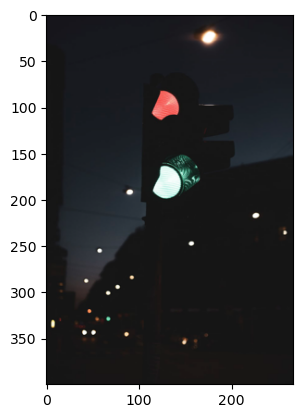

In [25]:
with open('images.pkl', 'rb') as f:
    images = pkl.load(f)

plt.imshow(images[0])

In [26]:
with open('target.pkl', 'rb') as f:
    labels = pkl.load(f)

print(labels[0])

trafficlight


In [27]:
sizes_df = pd.DataFrame([[img, img.shape[0], img.shape[1]] for img in images], columns=['image','height', 'width'])
sizes_df['label'] = labels
sizes_df.head()

KeyboardInterrupt: 

In [ ]:
sizes_df.groupby('label').count()

,image,height,width
label,,,
crosswalk,88,88,88
speedlimit,652,652,652
stop,76,76,76
trafficlight,61,61,61


In [ ]:
# Randomly drop 552 rows from the dataset that have the label 'speedlimit'
speedlimit_df = sizes_df[sizes_df['label'] == 'speedlimit']
speedlimit_df = speedlimit_df.sample(frac=1, random_state=27).reset_index(drop=True)
speedlimit_df = speedlimit_df.iloc[552:]
sizes_df = sizes_df[sizes_df['label'] != 'speedlimit']
sizes_df = pd.concat([sizes_df, speedlimit_df])
sizes_df.groupby('label').count()

,image,height,width
label,,,
crosswalk,88,88,88
speedlimit,100,100,100
stop,76,76,76
trafficlight,61,61,61


In [ ]:
images = np.array(sizes_df['image'])
labels = sizes_df['label'].tolist()

In [ ]:
target_size = (324, 365)

cv2.resize(images[0], (324, 365)).shape

(365, 324, 3)

In [ ]:
resized_images = [cv2.resize(img, target_size) for img in images]
sizes = set([img.shape for img in resized_images])
print(sizes)

{(365, 324, 3)}


In [ ]:
# Convert all images to floating point numpy arrays
float_images = [np.array(img).astype(np.float32) for img in resized_images]

In [ ]:
# Normalize images to a range between 0 and 1 by dividing all pixel values by the max of 255
normalized_images = [img/255 for img in float_images]

In [ ]:
X = np.array(normalized_images)


In [ ]:
y_label_encoder = LabelEncoder()
y_label_encoder.fit(labels)
y = y_label_encoder.transform(labels)
y[:100]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
list(y_label_encoder.classes_)

['crosswalk', 'speedlimit', 'stop', 'trafficlight']

In [ ]:
# Get the count of each value in y
unique, counts = np.unique(y, return_counts=True) 
print(np.asarray((unique, counts)).T)

[[  0  88]
 [  1 100]
 [  2  76]
 [  3  61]]


In [ ]:
# Split the training dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),     # Random rotation (10 degrees)
    tf.keras.layers.RandomTranslation(0.1, 0.1), # Random horizontal and vertical shift
    tf.keras.layers.RandomZoom(0.1),             # Random zoom
    tf.keras.layers.RandomContrast(0.1),         # Random contrast 
    tf.keras.layers.RandomFlip("horizontal"),     # Random horizontal
    tf.keras.layers.RandomFlip("vertical")       # Random vertical
])

In [ ]:
# Create an empty list for X and y augmentations
X_train_aug = []
y_train_aug = []

# Loop through the entire X_train set
for i in range(len(X_train)):
    # Select the original image and its y label
    img = X_train[i]
    label = y_train[i]
   
    # Ensure that the input data has the correct shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Add 20 new images for every original
    for j in range(20):
        # Create and append the image
        X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
        # Append the original label
        y_train_aug.append(label)

# Print the length of the augmented images and the labels
print(len(X_train_aug))
print(len(y_train_aug))

4340
4340


In [ ]:
# One hot encode the y data
y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))

In [ ]:
# Convert values to numpy arrays
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)

In [ ]:
# Shuffle the training data
X_train_np, y_train_np = shuffle(X_train_aug_np, y_train_aug_np)

# Shuffle the test data
X_test_np, y_test_np = shuffle(X_test_np, y_test_np)

In [ ]:
# Print the total number of one_hot_encoded columns
np.array(y_train_np).shape

(4340, 4)

In [ ]:
# Create a dictionary to store the train/test data
data = {
    'X_train': X_train_np,
    'X_test': X_test_np,
    'y_train': y_train_np,
    'y_test': y_test_np
}

# Save the dictionary to a pickle file
with open('signs_dict4.pkl', 'wb') as f:
    pkl.dump(data, f)